# Imported Libraries and Files

In [7]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import librosa
import seaborn as sns

import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchaudio
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os

import random
import torchaudio.transforms as T
import matplotlib.pyplot as plt
import matplotlib.pyplot

from utils.preprocessing import AudioDataset
from utils.models import Base_CNN, Base_CNN_Simplified, Base_CNN_Transformer, Base_CNN_GRU
from utils.train_utils import train_model, test_model, train_accuracy_model, plot_history, plot_confusion_matrix
from utils.data_loader import load_cremad, load_ravdess, load_tess, load_savee

# Necessary Paths

In [8]:
cremad_path = '/projectnb/ec523/projects/teamSER/cremad/'
ravdess_path = '/projectnb/ec523/projects/teamSER/ravdess/audio_speech_actors_01-24/'
tess_path = '/projectnb/ec523/projects/teamSER/tess/TESS Toronto emotional speech set data/'
savee_path = '/projectnb/ec523/projects/teamSER/savee/ALL/'

training_split = 0.8
testing_split = 0.2
batch_size = 32
sampling_rate = 22000

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Data Loading and Preprocessing

In [9]:
# cremad_df = load_cremad(cremad_path)
# ravdess_df = load_ravdess(ravdess_path)
tess_df = load_tess(tess_path)
# savee_df = load_savee(savee_path)

In [10]:
# Create a dataframe that contains all the emotion labels and paths from all the datasets
df = pd.concat([tess_df], axis=0)
df = df.reset_index(drop=True)
df = df[~df['Emotion'].isin(['calm', 'surprise'])]
df['Emotion'].value_counts()

Emotion
disgust      400
fear         400
happiness    400
neutral      400
anger        400
sadness      400
Name: count, dtype: int64

In [11]:
encoder = LabelEncoder()
df['Emotion'] = encoder.fit_transform(df['Emotion'])
df['Emotion'].value_counts()

Emotion
1    400
2    400
3    400
4    400
0    400
5    400
Name: count, dtype: int64

In [12]:
dataset = AudioDataset(df)

all_indices = list(range(len(dataset)))
all_labels = dataset.labels

train_idx, test_idx = train_test_split(
    all_indices, test_size=testing_split, stratify=all_labels, random_state=42)

train_set = torch.utils.data.Subset(dataset, train_idx)
test_set = torch.utils.data.Subset(dataset, test_idx)

train_set.dataset.transform = True
test_set.dataset.transform = False

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)

# Base CNN

In [13]:
model = Base_CNN().to(device)

criterion = nn.CrossEntropyLoss().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
trained_model, history = train_model(model, optimizer, criterion, device, train_loader, test_loader, num_epochs=5)

Epoch 1/5 - Loss: 73.1780 | Train Acc: 98.91% | Val Acc: 99.17%
Epoch 2/5 - Loss: 9.3833 | Train Acc: 100.00% | Val Acc: 100.00%
Epoch 3/5 - Loss: 2.5529 | Train Acc: 99.79% | Val Acc: 100.00%
Epoch 4/5 - Loss: 1.4266 | Train Acc: 100.00% | Val Acc: 100.00%
Epoch 5/5 - Loss: 0.5693 | Train Acc: 100.00% | Val Acc: 100.00%

Best Val Accuracy: 100.00%


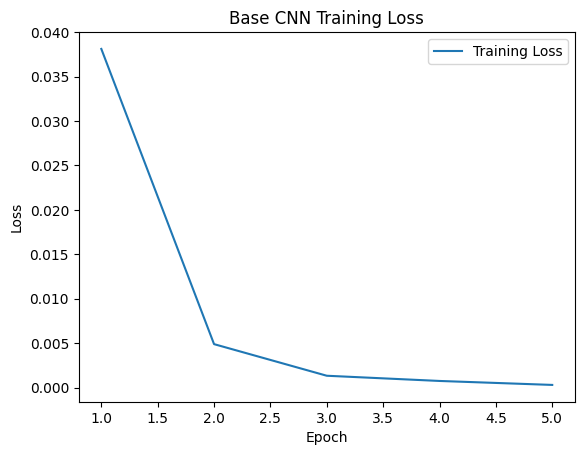

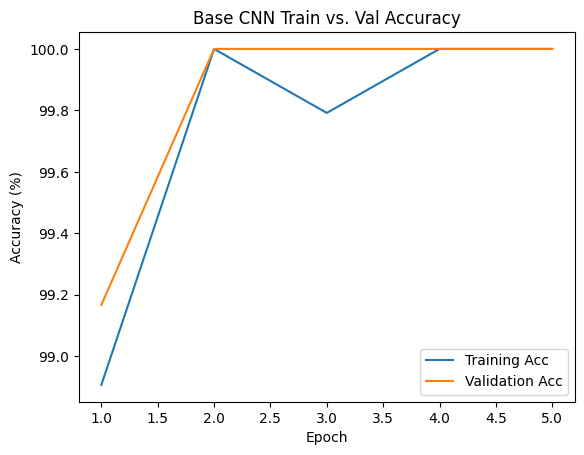

In [15]:
plot_history(history, 'Base CNN')

<Figure size 800x600 with 0 Axes>

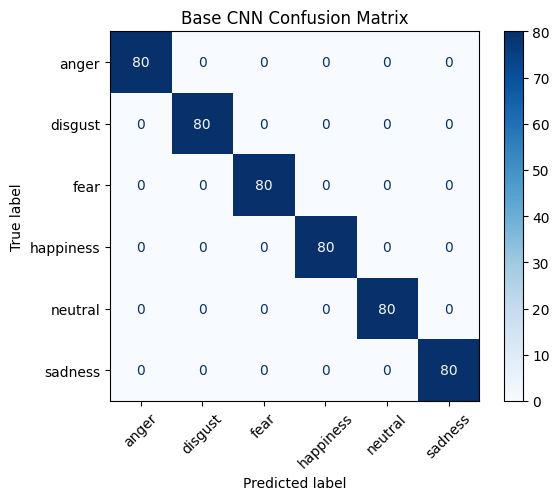

In [16]:
plot_confusion_matrix(trained_model, test_loader, device, "Base CNN Confusion Matrix")